# Machine Learning Capstone
### Kaggle Zillow Competition
Zack Thoutt  
June 8th, 2017  

---

## Definition
#### Project Overview

Purchasing a home is something that almost everyone in the United States does at least once in their life. I have recently been through this process and in my experience, it's tough. Combined with the stress of trying to figure out if a home meets all of your needs--close to work, good public transportation, walkability, etc.--you also have to deal with real estate agents and figuring out how much you're willing to offer for a property. I wish that buying a house was like shopping at a store--you could shop around and buy things for the price on their price tag--but the home-buying process is much more complicated because nobody knows exactly what the price tag is until someone buys it. 

For my wife and I, figuring out what price to offer was the most difficult part of buying a house. The current housing market where we live (Boulder, CO) is definitely a sellers market. People are flocking to my hometown from all over the country with a lot of cash and the real estate market has taken off as a result. The home that we now own had 34 offers in one weekend! It's common practice right now for listing agents to list a home well below what they think it's worth and then let dozens of people bid up the price. When you are one of the people making an offer you want to bid high enough to win, but you also don't want to over pay and lose a lot of money. We used Zillow and Redfin price estimates extensively, which is why I chose to build a model that predicts home values as my capstone project. Knowing the current value of a house before making an offer on it can help people decide if certain properties are in their price range and what they are willing to offer based on the value of the house.

#### Problem Statement
My capstone project will train and tune an [xgBoost](https://github.com/dmlc/xgboost) classifier that predicts the value of a home in USD given a set of statistics about that home, such as the number of bedrooms, neighborhood, year it was built, etc. This capstone is based off of the [Zillow Kaggle Competition](https://www.kaggle.com/c/zillow-prize-1), so the model will be trained and tested against the dataset supplied by Zillow for competition competitors. I will also use K-fold cross validation so that all of my data can be used to train the model.

I will be using an xgBoost classifier because it is robust to missing data and high dimensions. xgBoost also regularly wins Kaggle competions and consistantly performs well on structured datasets like this one. xgBoost is a supervised learning algorithm that trains a series of decision trees and combines them into a single model. The xgBoost algorithm using a technique called boosting to link the individual decision trees together. The boosting algorithm looks at which data points the model is predicting worst and weights those more heavily when training the next decision tree. This is in contrast to bagging, which trains the decision trees independently and combines them using a voting system.

xgBoost has about 20 parameters that will need to be tuned, such as `max_depth`, which defines the maximium depth any one decision tree can go before making a prediction. If the depth is set too low, the model will be unable to accurately represent the complexities of the data; if the depth is set too high, the model will overfit the data. I will need to do a good amount of experimentation and parameter tuning to get the model training optimally. In order to determine the best combination of parameters for this dataset, I will use `GridSearchCV` to train a bunch of different models and determine which parameter combination give the best results.

#### Metrics
I will judge my model based on the log error of the home price, which is how the Kaggle competition will be grading submissions. Taking the log error helps correct for the skew of home price data (there are some homes that are worth significantly more than the average home). The log error is defined as below:

$$logError_i = log(Predicted Home Price_i) - log(Most Recent Sale Price_i)$$

The full metric that I will be trying to minimize will be the mean absolute error (MAE) of the log errors. We take the absolute value so that you can't get zero error and never predict anything right (positives cancel out negatives). The MAE for log errors is defined as follows:

$$MAE = \sum_{i} |EstimatedLogError_i - ActualLogError_i|$$ 

This metric treats over and under estimates the same and doesn't penalize predictions that are way off more than predictions that are off by a little. I would probably personally use the mean squared error (MSE) if it were up to me so that worse predictions are punushed more, but the MAE should work fine in this case.

## Analysis
#### Data Exploration
In order to load the data and start training a model, I need to load both the properties data and the training data. The properties data contains 58 features, about 20 of which are categorical. In order to later one-hot encode this data and have the learning algorithms treat these fields correctly, I specify which features should be treated as categorical.

In [1]:
import pandas as pd
import numpy as np

properties = pd.read_csv('properties_2016.csv', dtype={
    'airconditioningtypeid': 'category',
    'architecturalstyletypeid': 'category',
    'buildingclasstypeid': 'category',
    'buildingqualitytypeid': 'category',
    'decktypeid': 'category',
    'hashottuborspa': 'category',
    'heatingorsystemtypeid': 'category',
    'pooltypeid10': 'category',
    'pooltypeid2': 'category',
    'pooltypeid7': 'category',
    'propertycountylandusecode': 'category',
    'propertylandusetypeid': 'category',
    'propertyzoningdesc': 'category',
    'regionidcity': 'category',
    'regionidcounty': 'category',
    'regionidneighborhood': 'category',
    'regionidzip': 'category',
    'storytypeid': 'category',
    'typeconstructiontypeid': 'category',
    'fireplaceflag': 'category',
    'taxdelinquencyflag': 'category'
})
raw_data = pd.read_csv('train_2016.csv')
test_data = pd.read_csv('sample_submission.csv')
test_data['parcelid'] = test_data['ParcelId']

When pandas reads the data in some of the datatypes are a bit overkill. All of the float values in the data are 64 bit floats, which will require a lot more memory and training time to train an xgBoost learner. I am going to convert all 64 bit floats to 32 bit floats.

In [2]:
for feature, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[feature] = properties[feature].astype(np.float32)

In order to create the training and testing sets, we need to join the properties data with the training data based on the `parcelid` attribute. This is an easy operation with pandas, which has a merge function that is a lot like a join in SQL. I will do a left join on `parcelid` so that there is a row for all of the parcels in the training data and the property information gets added. I also don't want to train the model on the `parcelid` or the `logerror` (the label), so I'm going to drop those columns.

Below are a few visualizations to familiarize yourself with the data. As you can see, there is a lot of non-normality, outliers, and missing values. Some of these I will have to deal with, but most of them are not a problem for xgBoost since it is a tree-based algorithm.

In [3]:
from IPython.display import display

train = raw_data.merge(properties, how='left', on='parcelid')
X = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y = train['logerror'].values
print(X.shape, y.shape)
display(X.head())

X_test = test_data.merge(properties, how='left', on='parcelid')

(90811, 57) (90811,)


,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,1,NaN,NaN,2.0,3.0,NaN,4,2.0,NaN,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,1,NaN,NaN,3.0,2.0,NaN,4,3.0,NaN,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,1,NaN,NaN,2.0,2.0,NaN,4,2.0,NaN,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13


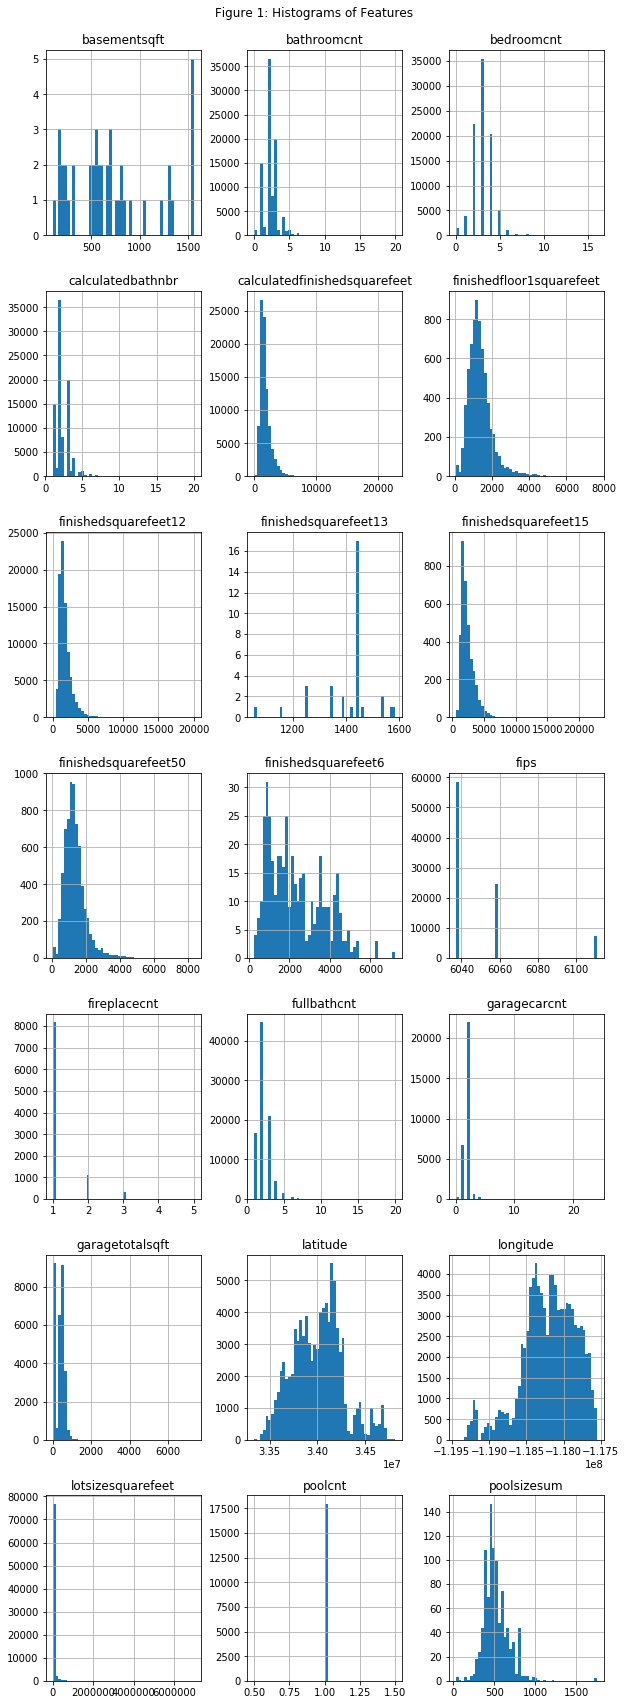

In [157]:
import matplotlib.pyplot as plt
plt.style.use = 'default'
%matplotlib inline

# first half of histograms
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10,30));
X[X.columns[:28]].hist(bins=50, ax=axes);
plt.suptitle('Figure 1: Histograms of Features ', x=0.5, y=0.9, ha='center');

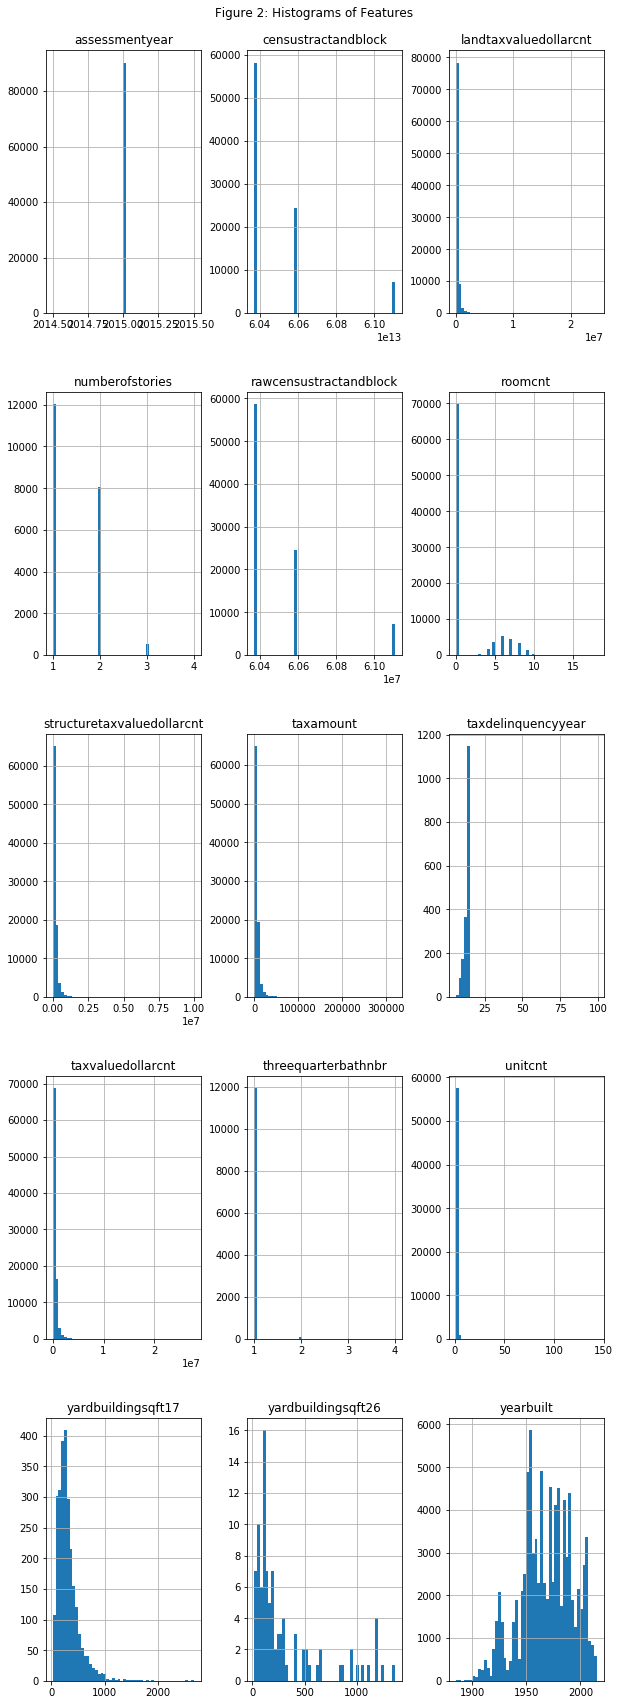

In [159]:
# seconds half of histograms
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,30));
X[X.columns[28:]].hist(bins=50, ax=axes);
plt.suptitle('Figure 2: Histograms of Features ', x=0.5, y=0.9, ha='center');

### Visualizations
If I were to guess I would say that number of bedrooms, number of bathrooms, total square footage, and location will be the most predictive features of our model. The square footage is probably the most obvious feature that will be important because given a location, you pay a fairly consistent price per square foot for real estate. A few of the main factors that can change the price per square foot holding both location and total square feet constant are the number of bedrooms and bathrooms. Many people have kids and need several beds and baths to even consider a home. In contrast, if you remodel your house and knock out a bedroom wall to make your living room larger, you have likely just decreased your property value significantly. Finally, the location also speaks for itself; a 2,000 square foot house in Wyoming might be cheap while a 2,000 square foot house in Manhattan would be very expensive.

Let's take a deeper dive into a few of these features and see what the data looks like.

---

##### Total Finished Square Feet

The total finished square feet is one of the most important features of a house. More space costs more money holding all other variables constant. Let's look at how total square feet is distributed.

The minimum finished square feet is 2
The maximum finished square feet is 22741
The mean finished square feet is 1773
The median finished square feet is 1540


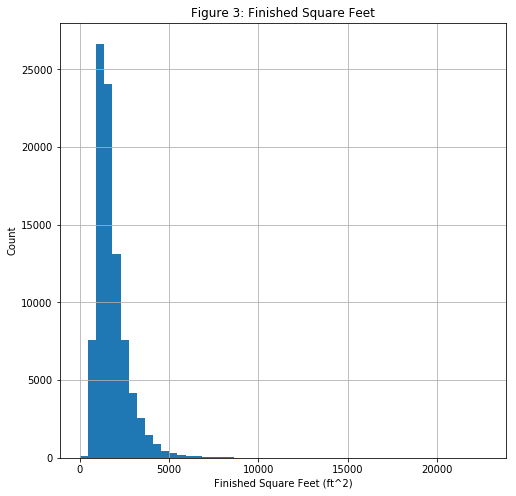

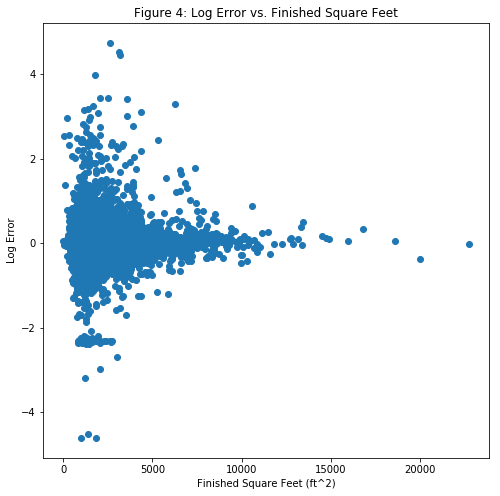

In [160]:

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_xlabel('Finished Square Feet (ft^2)')
ax.set_ylabel('Count')
ax.set_title('Figure 3: Finished Square Feet')
X['calculatedfinishedsquarefeet'].hist(bins=50, ax=ax);

fig2 = plt.figure(figsize=(8,8))
plt.scatter(X['calculatedfinishedsquarefeet'], y);
plt.xlabel('Finished Square Feet (ft^2)')
plt.ylabel('Log Error')
plt.title('Figure 4: Log Error vs. Finished Square Feet')

min_sqft = np.min(X['calculatedfinishedsquarefeet'])
max_sqft = np.max(X['calculatedfinishedsquarefeet'])
mean_sqft = np.mean(X['calculatedfinishedsquarefeet'])
median_sqft = np.nanmedian(X['calculatedfinishedsquarefeet'])

print('The minimum finished square feet is {:.0f}'.format(min_sqft))
print('The maximum finished square feet is {:.0f}'.format(max_sqft))
print('The mean finished square feet is {:.0f}'.format(mean_sqft))
print('The median finished square feet is {:.0f}'.format(median_sqft))

The square footage of homes is heavily skewewed left. The mean and median square feet are around 1500-1750 sqft, which is about what I would expect. The mean is quite a bit higher than the median because of the skewedness of the data. If I were planning to use other supervised learning algorithms such as SVM or linear regression, I would use a log transformation on the data to make it closer to normal. Since tree-ensembled algorithms don't require normally distributed data, I will leave it as is.

The log error based on the square footage is interesting to look at. It appears that really large houses are actaully easier to value than smaller houses. This could be logically justified by the fact that smaller properties will have more activity and interest which adds uncertainty and randomness to the data while larger homes have a small subset of buyers/sellers and change hands more slowly over time.

##### ZIP Code
In real estate it's all about location, location, location, right? I expect the ZIP code and other location-related features to play a large role in predicting house values. A 3,000 square foot home in the middle of Wyoming will be worth a small fraction of the same home in New York City. 

Unfortunately, we are only provided with the log error of the Zillow estimate and not the actual home value, so it will be difficult to visualize this relationship. Instead, let's take a look at how home size might change based on zip code. I would expect that places with smaller median home sizes will be more expensive in general, so this should give us an idea of how zip code will help our learner eventually predict.

In [6]:
zip_1 = '97101'
zip_2 = '96473'
zip_3 = '97001'

med_sqft_1 = np.nanmedian(X[X['regionidzip'] == zip_1]['calculatedfinishedsquarefeet'])
med_sqft_2 = np.nanmedian(X[X['regionidzip'] == zip_2]['calculatedfinishedsquarefeet'])
med_sqft_3 = np.nanmedian(X[X['regionidzip'] == zip_3]['calculatedfinishedsquarefeet'])

print('Median finished square feet in {}: {:.0f}'.format(zip_1, med_sqft_1))
print('Median finished square feet in {}: {:.0f}'.format(zip_2, med_sqft_2))
print('Median finished square feet in {}: {:.0f}'.format(zip_3, med_sqft_3))


Median finished square feet in 97101: 1746
Median finished square feet in 96473: 1327
Median finished square feet in 97001: 1035


Here are three zip codes that I randomly selected and as you can see the square footage varies by quite a bit. The first zip code has about the same median square footage as the dataset as a whole. The final zip code only has a median square footage of 1,035 square feet. This is likely a zip code located in a city where houses are smaller. I would guess that the price of houses in a given zip code equal to that zip code's median square footage will be similar in total cost across zip codes. In other words, the cost per square foot will be high in zip codes where the median square footage is smaller, but overall houses will be priced relative to the alternatives in the area.

### Algorithms
As I outlined in the Solution section above, my initail plan is to use a supervised learning algorithm called xgBoost to predict the Zillow log error. After the base class is trained I will focus on parameter tuning. Parameter tuning will be done with `GridSearchCV`, which will look at various combinations of parameters and determine the best set of parameters. My final model will be trained using k-fold cross-fold validation, which will allow the model to train on all of the data. If I have time, I might also experiment with other supervised learning algorithms and ensembling them to get a better score.

xgBoost is a tree ensemble machine learning algorithm, which means that it trains a set of simple decision trees called weak learners and combines them into a single model that has more predictive power. There are two main ways to ensemble trees like this--boosting and bagging. The boosting method trains the first tree, looks at which data points the tree was worst at predicting, and then trains the second tree with the points with the highest error weighted more. This process is repeated hundreds or thousands of times and you end up with a collection of trees that model different parts of the data well and combine to make a strong predictor. In contrast, when you ensemble using bagging each tree is created independently and the trees are combined in the end with a voting system. The trees end up different because you show each tree different cuts of data. xgBoost uses bagging to ensemble the trees into a single model.

xgBoost has many hyperparameters that you can tune to make the model generalize better and model the complexities of the data. In particular, I will focus on tuning `eta`, `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, and `gamma` to improve my model. Here is a break down of what each of the parameters does and how it can be adjusted to imporove the model.

- `eta`: the learning rate of the algorithm, which defines how much the weights of the data points change during the boosting steps. After each tree is built the model is evaluated to see which points it is best and worst at predicting. The worse the model is predicting a given point, the more that point is weighted in the next tree. The `eta` defines how aggressive each weight change is--higher values make the weights change faster, but can overfit; lower values generalize to the data more, but take much longer to train.

- `max_depth`: the maximum depth that any one tree can have in the ensemble. This parameter helps you manage overfitting--too high of a depth and you will overfit, too low and your model won't be complex enough to model the data.

- `min_child_weight`: the sensitivity to the algorithm deciding if it should add a new leaf to a given tree or not. The max depth will cap the depth of the tree, but if you have the max depth set to 6, some of your trees might be depth 3 and others depth 5. the `min_child_weight` defines how much improvement in the predictive power of the decision tree is needed to justify adding another leaf. A higher value will result in more trees near the max depth and a lower value will result in smaller trees. This also helps us control overfitting by requiring more gains to justify more complicated trees. 

- `subsample`: the proportion of the training data that any one tree is trained on. For example, if `subsample`=0.5, then each tree will see a randomly selected sample of half the data. This allows the trees to focus on different aspects of the data and results in a more powerful model. A smaller `subsample` also helps reduce overfitting because each tree is seeing more different data.

- `colsample_bytree`: the proportion of features that any one tree is trained on. This is very similar to `subsample`, only instead of limiting the data points, we limit the features. Again, showing each tree a different cut of the data can help make the overall model more generalizable and is less likely to overfit.

- `gamma`: this is very similar to `min_child_weight` in that it helps the algorithm decide when to stop adding leaves to a tree. The difference between the two is the metric used to make that decision. `gamma` defines the *loss* required to continue adding leafs while `min_child_weight` defines the *hessian* required to continue adding leaves. In order to add a leaf, both conditions need to be satisfied when they are both set to non-zero values.

### Benchmark

In my proposal I originally stated that I would use the average price per square foot of the entire data set to estimate the home value as a benchmark. However, the data is structured a little different than I originally thought. the competition actually occurs in two stages and in the first stage you only have the log error defined above to make predictions on.

The new benchmark that I will use is to predict that all of the log errors are zero. They should theoretically be centered on zero unless Zillow's current prediction algorithm is bias towards over or under pricing houses, so this should give me a good benchmark to go off of.

In [7]:
from sklearn.metrics import mean_absolute_error

benchmark_y = np.zeros(y.shape)
benchmark_mae = mean_absolute_error(benchmark_y, y)
print('Benchmark MAE: {:.4f}'.format(benchmark_mae))

Benchmark MAE: 0.0693


## Methedology
### Data Processing

Since xgBoost and other tree-based algorithms are robust to non-normality and outliers, I don't need to perform any transformations to deal with these issues. There are a few other processing steps that I will take to prepare the data and reduce its dimensionality, such as dealing with missing values, scaling features, and converting categorical variables to many one-hot encoded variables. These data preperations will improve the predictive cababilities of my model while significantly reducing training time.

In [8]:
print('We are starting with {} rows and {} features'.format(X.shape[0], X.shape[1]))

We are starting with 90811 rows and 57 features


##### Filling missing values

xgBoost and other models like it don't require there to be no missing values, but it is often a good idea to fill them in anyways. In many cases, the lack of data can actually be predictive, so we want to be able to include that information in the model. I filled in all of the missing values with -999, a number that should not occur in anywhere in the data otherwise. This should be especially helpful considering that we are essentially modeling the Zestimate accuracy. It is likely that the Zestimate is off more when there are more missing values, so having the missing values modelable while maintaining their information should help me train a more predictive model.

In [9]:
continuous_features = list(X.select_dtypes(include=['float32']).columns)

X_filled = X.copy()
X_filled[continuous_features] = X_filled[continuous_features].fillna(value=-999.0)

X_test_filled = X_test.copy()
X_test_filled[continuous_features] = X_test_filled[continuous_features].fillna(value=-999.0)

##### Scale continuous features
It is also not necessary to scale features when using xgBoost as the model does not care about relative magnitude. The reason that I have chosen to scale them is more of a numerical computation precaution. First, having smaller values should slightly speed up training time. Second, there are both small and large values in the dataset, which can lead to computational error in certain cases. Finally, it is considered best practice to scale features because you may decide you want to use a different model that is more sensetive to feature scaling, such as support vector machines or principal component analysis. 

I am using the MaxAbsScaler provided by sklearn, which takes each feature and squashes it down so that the max absolute value of each feature is 1. This should scale our data down without centering it and changing its distribution. 

In [10]:
from sklearn.preprocessing import MaxAbsScaler

scaler1 = MaxAbsScaler()
features_raw = X_filled.copy()
features_raw[continuous_features] = scaler1.fit_transform(features_raw[continuous_features])

scaler2 = MaxAbsScaler()
X_test_raw = X_test_filled.copy()
X_test_raw[continuous_features] = scaler2.fit_transform(X_test_raw[continuous_features])

##### Drop unneeded columns
There are a few features in the dataset that should be dropped because they probably don't add a lot of predictive power, but they do add a lot of dimensionality. Each of the four features that I have outlined below relate the the location of a property, which is already covered by several other features with fewer dimensions, such as longitude/latitude or zip code. The features that I'm dropping should be highly correlated with longitude/latitude, zip code, or one of the other location-based features left in the data. As you can see, the dimensionality reduction is significant. `propertyzoningdesc` in particular made up almost 75% of the dimensionality of the dataset with 5638 possible categories that would be encoded into an equal number of features.

In [11]:
theoretical_max_dimensions = pd.get_dummies(features_raw).shape[1]
print('If we were to train now the dataset would have {} dimensions'.format(theoretical_max_dimensions))

If we were to train now the dataset would have 7110 dimensions


In [12]:
prop_land_code = len(features_raw.select_dtypes(include=['category'])['propertycountylandusecode'].cat.categories.values)
prop_zoning = len(features_raw.select_dtypes(include=['category'])['propertyzoningdesc'].cat.categories.values)
region_neigh = len(features_raw.select_dtypes(include=['category'])['regionidneighborhood'].cat.categories.values)
region_city = len(features_raw.select_dtypes(include=['category'])['regionidcity'].cat.categories.values)

print('{} contributes {:.0f} dimensions or {:.2f}%'.format('propertycountylandusecode', prop_land_code, prop_land_code/theoretical_max_dimensions*100))
print('{} contributes {:.0f} dimensions or {:.2f}%'.format('propertyzondingdesc', prop_zoning, prop_zoning/theoretical_max_dimensions*100))
print('{} contributes {:.0f} dimensions or {:.2f}%'.format('regionidneighborhood', region_neigh, region_neigh/theoretical_max_dimensions*100))
print('{} contributes {:.0f} dimensions or {:.2f}%'.format('regionidcity', region_city, region_city/theoretical_max_dimensions*100))

features_raw_parsed = features_raw.drop(['propertyzoningdesc', 'propertycountylandusecode', 'regionidneighborhood', 'regionidcity'], axis=1)
X_test_raw_parsed = X_test_raw.drop(['propertyzoningdesc', 'propertycountylandusecode', 'regionidneighborhood', 'regionidcity'], axis=1)

total_dimension_reduction = prop_land_code + prop_zoning + region_neigh + region_city

print('Overall, this reduced the dataset by {:.0f} dimensions or {:.2f}%'.format(total_dimension_reduction, total_dimension_reduction/theoretical_max_dimensions*100))

propertycountylandusecode contributes 240 dimensions or 3.38%
propertyzondingdesc contributes 5638 dimensions or 79.30%
regionidneighborhood contributes 528 dimensions or 7.43%
regionidcity contributes 186 dimensions or 2.62%
Overall, this reduced the dataset by 6592 dimensions or 92.71%


##### One-hot encode categorical variables

My final data processing step is translating all of the categorical features into one-hot encoded features. This will allow the model to train on the categorical features without accidentally modeling on magnitude or ordinality of the categorical features by treating them as continuous features. `get_dummies` is a method supplied by `pandas` one-hot encodes dataframes by turning each category in all of the categorical features into a single boolean feature. 

In [13]:
features = pd.get_dummies(features_raw_parsed)
X_test_features = pd.get_dummies(X_test_raw_parsed)
print('The final dimensionality before training is {:.0f}'.format(features.shape[1]))

The final dimensionality before training is 518


You can see from the print statement above that the 58 original features have been transformed into 518 features. The expansion in dimensions is the result of one-hot encoding categorical variables, which would have given a theoretical maximum 7077 dimensions. By analyzing the data I was able to pluck out a few high-dimension, highly-correlated features, which should improve our training time without sacrificing predictive strength. Now that the data is ready, we can start trainging the model!

### Implementation

Now that the data is processed, I will train an un-tuned xgBoost model and see how it performs. Later I will tune hyperparameters, but for now I just want to see how well my algorithm of choice does out of the box.

In [15]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

params = {'n_estimators': 50, 'seed': 1993, 'objective': 'reg:linear'}
cv_params = {}
gs_xgb_0 = GridSearchCV(xgb.XGBRegressor(**params), cv_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=10)
gs_xgb_0.fit(features, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................................... , score=-0.066047 -  54.6s
[CV] ...................................... , score=-0.068124 -  55.3s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.9s remaining:  1.4min


[CV] ...................................... , score=-0.066926 -  55.6s
[CV] ...................................... , score=-0.071347 -  55.8s


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.3s remaining:   37.5s


[CV] ...................................... , score=-0.074693 -  56.3s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1993, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [127]:
initial_mae = gs_xgb_0.best_score_
print('My initial model finished with {:.4f} MAE, which is a {:.2f}% decrease from the benchmark'.format(-initial_mae, -(benchmark_mae + initial_mae)/benchmark_mae*100))



My initial model finished with 0.0694 MAE, which is a 0.16% decrease from the benchmark


The initial model does a decent job at predicting the MAE, but it actually does worse than our benchmark model. Since all of the log errors are quite small and center close to zero, I have a feeling that the benchmark model is actually a pretty good model as far as benchmarks go. I still think that we can beat it so let's start refining the xgBoost model by tuning its parameters.

### Refinement
My strategy for refining the xgBoost model was to focus on tuning the hyperparameters. There are over a dozen hyperparameters that you can tune, so finding the right combination is non-trivial. Furthermore, hyperparameter settings make a huge difference in the predictive strenght of a model. Tuning features one way or the other can help you balance modeling the complexities of the data and overfitting. 

I took an iterative approach to tuning the parameters. I use `GridSearchCV` provided by `sklearn` to test out different combinations of parameters while also performing 5-fold cross validation. 

Doing the grid search in stages is advantageous because the search will train a 5-fold model for each combination of parameters supplied. That means that the number of fits required grows exponentially, not linearly. By doing them a few at a time, I save hours of training time. The sacrifice is that if two parameters that are not searched together are not independent of each other, then you may end up with unperfect parameter tunings. This is a small price to pay and either way the parameters should be in the same ballpark whether they are searched all together or in chunks.

The 5-fold cross validation is handy because it allows me to make use of all of the data that I'm given, while still being able to evaluate the strength of my model. It also reduces variance by ensembling models, which should make my model more generalizable.

**Note that I actually ran each of the grid searches below several times with varying values before deciding that the parameters were in the ballpark of where I think that they should be. Since it would have been tedious to show all of these steps, I only saved the final grid search that I did for each iteration to demonstrate the process.**

##### `max_depth` and `min_child_weight`

I decided to start tuning `max_depth` and `min_child_weight` because they both relate to the structure of the trees used by the xgBoost and they are both important to avoid overfitting. `max_depth` puts a ceiling on the depth that any one tree can be. `min_child_weight` defines the minimum number of instances needed in each node, so smaller values are more aggressive. 

In [355]:
cv_params = {'max_depth': [3, 4, 5], 'min_child_weight': [0.05, 0.25, 0.5]}
ind_params = {'learning_rate': 0.3, 'n_estimators': 50, 'seed': 1993, 'subsample': 0.5, 'objective': 'reg:linear', 'colsample_bytree': 0.4, 'gamma': 0}
gs_xgb_1 = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=10)
gs_xgb_1.fit(features, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=0.05 ..............................
[CV] max_depth=3, min_child_weight=0.05 ..............................
[CV] max_depth=3, min_child_weight=0.05 ..............................
[CV] max_depth=3, min_child_weight=0.05 ..............................
[CV] max_depth=3, min_child_weight=0.05 ..............................
[CV] max_depth=3, min_child_weight=0.25 ..............................
[CV] max_depth=3, min_child_weight=0.25 ..............................
[CV] max_depth=3, min_child_weight=0.25 ..............................
[CV] .... max_depth=3, min_child_weight=0.25, score=-0.068892 -  55.9s
[CV] max_depth=3, min_child_weight=0.25 ..............................
[CV] .... max_depth=3, min_child_weight=0.05, score=-0.075473 -  58.7s
[CV] max_depth=3, min_child_weight=0.25 ..............................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.1s


[CV] .... max_depth=3, min_child_weight=0.25, score=-0.075473 -  58.4s
[CV] .... max_depth=3, min_child_weight=0.05, score=-0.068892 -  58.8s
[CV] max_depth=3, min_child_weight=0.5 ...............................
[CV] .... max_depth=3, min_child_weight=0.05, score=-0.071378 -  59.0s
[CV] .... max_depth=3, min_child_weight=0.05, score=-0.067574 -  58.9s
[CV] .... max_depth=3, min_child_weight=0.25, score=-0.071378 -  58.4s
[CV] max_depth=3, min_child_weight=0.5 ...............................
[CV] .... max_depth=3, min_child_weight=0.05, score=-0.066948 -  58.8s
[CV] max_depth=3, min_child_weight=0.5 ...............................
[CV] max_depth=3, min_child_weight=0.5 ...............................
[CV] max_depth=3, min_child_weight=0.5 ...............................
[CV] max_depth=4, min_child_weight=0.05 ..............................
[CV] .... max_depth=3, min_child_weight=0.25, score=-0.067574 - 1.1min
[CV] max_depth=4, min_child_weight=0.05 ..............................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min


[CV] ..... max_depth=3, min_child_weight=0.5, score=-0.068892 - 1.1min
[CV] max_depth=4, min_child_weight=0.05 ..............................
[CV] .... max_depth=3, min_child_weight=0.25, score=-0.066948 - 1.2min
[CV] ..... max_depth=3, min_child_weight=0.5, score=-0.075473 - 1.2min
[CV] ..... max_depth=3, min_child_weight=0.5, score=-0.071378 - 1.2min
[CV] max_depth=4, min_child_weight=0.05 ..............................
[CV] max_depth=4, min_child_weight=0.05 ..............................
[CV] max_depth=4, min_child_weight=0.25 ..............................
[CV] ..... max_depth=3, min_child_weight=0.5, score=-0.067574 - 1.2min
[CV] max_depth=4, min_child_weight=0.25 ..............................
[CV] ..... max_depth=3, min_child_weight=0.5, score=-0.066948 - 1.2min
[CV] max_depth=4, min_child_weight=0.25 ..............................
[CV] .... max_depth=4, min_child_weight=0.05, score=-0.075829 - 1.5min
[CV] max_depth=4, min_child_weight=0.25 ..............................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min


[CV] .... max_depth=4, min_child_weight=0.05, score=-0.071927 - 1.4min
[CV] max_depth=4, min_child_weight=0.25 ..............................
[CV] .... max_depth=4, min_child_weight=0.05, score=-0.069298 - 1.4min
[CV] max_depth=4, min_child_weight=0.5 ...............................
[CV] .... max_depth=4, min_child_weight=0.05, score=-0.067662 - 1.4min
[CV] max_depth=4, min_child_weight=0.5 ...............................
[CV] .... max_depth=4, min_child_weight=0.25, score=-0.075829 - 1.4min
[CV] max_depth=4, min_child_weight=0.5 ...............................
[CV] .... max_depth=4, min_child_weight=0.05, score=-0.067957 - 1.4min
[CV] max_depth=4, min_child_weight=0.5 ...............................
[CV] .... max_depth=4, min_child_weight=0.25, score=-0.069298 - 1.4min
[CV] max_depth=4, min_child_weight=0.5 ...............................
[CV] .... max_depth=4, min_child_weight=0.25, score=-0.071927 - 1.4min
[CV] max_depth=5, min_child_weight=0.05 ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min


[CV] ..... max_depth=4, min_child_weight=0.5, score=-0.075829 - 1.2min
[CV] max_depth=5, min_child_weight=0.05 ..............................
[CV] ..... max_depth=4, min_child_weight=0.5, score=-0.071927 - 1.2min
[CV] ..... max_depth=4, min_child_weight=0.5, score=-0.069298 - 1.2min
[CV] max_depth=5, min_child_weight=0.05 ..............................
[CV] max_depth=5, min_child_weight=0.25 ..............................
[CV] ..... max_depth=4, min_child_weight=0.5, score=-0.067957 - 1.2min
[CV] max_depth=5, min_child_weight=0.25 ..............................
[CV] ..... max_depth=4, min_child_weight=0.5, score=-0.067662 - 1.2min
[CV] max_depth=5, min_child_weight=0.25 ..............................
[CV] .... max_depth=5, min_child_weight=0.05, score=-0.076053 - 1.5min
[CV] max_depth=5, min_child_weight=0.25 ..............................
[CV] .... max_depth=5, min_child_weight=0.05, score=-0.072327 - 1.4min
[CV] max_depth=5, min_child_weight=0.25 ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  6.2min remaining:  1.8min


[CV] .... max_depth=5, min_child_weight=0.05, score=-0.068149 - 1.5min
[CV] max_depth=5, min_child_weight=0.5 ...............................
[CV] .... max_depth=5, min_child_weight=0.25, score=-0.072327 - 1.5min
[CV] max_depth=5, min_child_weight=0.5 ...............................
[CV] .... max_depth=5, min_child_weight=0.25, score=-0.070079 - 1.5min
[CV] .... max_depth=5, min_child_weight=0.25, score=-0.068434 - 1.4min
[CV] .... max_depth=5, min_child_weight=0.25, score=-0.068149 - 1.4min


[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  6.6min remaining:   49.1s


[CV] ..... max_depth=5, min_child_weight=0.5, score=-0.076053 - 1.1min
[CV] ..... max_depth=5, min_child_weight=0.5, score=-0.072327 - 1.0min
[CV] ..... max_depth=5, min_child_weight=0.5, score=-0.070079 -  59.2s
[CV] ..... max_depth=5, min_child_weight=0.5, score=-0.068434 -  59.0s
[CV] ..... max_depth=5, min_child_weight=0.5, score=-0.068149 -  58.9s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1993, silent=True, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'min_child_weight': [0.05, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [356]:
print(gs_xgb_1.best_params_)

{'max_depth': 3, 'min_child_weight': 0.05}


##### `subsample` and `colsample_bytree`
The next set of parameters that I tuned were also related, only this time they govern how much data is supplied to each tree. The `subsample` feature defines the percentage of data samples that the tree will be given to train on while the `colsample_bytree` feature defines the percentage of features from the data that the tree will be given to train on. These are both effective ways to reduce variance and make a model more general because each tree in the ensemble is seeing different data and focusing on different patterns. 

In [357]:
cv_params = {'subsample': [0.3, 0.5, 0.7], 'colsample_bytree': [0.3, 0.5, 0.7]}
ind_params = {'learning_rate': 0.3, 'n_estimators': 100, 'seed': 1993, 'max_depth': 3, 'min_child_weight': 0.05 , 'objective': 'reg:linear', 'gamma': 0}
gs_xgb_2 = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=10)
gs_xgb_2.fit(features, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.3, subsample=0.3 .............................
[CV] colsample_bytree=0.3, subsample=0.3 .............................
[CV] colsample_bytree=0.3, subsample=0.3 .............................
[CV] colsample_bytree=0.3, subsample=0.3 .............................
[CV] colsample_bytree=0.3, subsample=0.3 .............................
[CV] colsample_bytree=0.3, subsample=0.5 .............................
[CV] colsample_bytree=0.3, subsample=0.5 .............................
[CV] colsample_bytree=0.3, subsample=0.5 .............................
[CV] ... colsample_bytree=0.3, subsample=0.3, score=-0.072644 -  57.8s
[CV] colsample_bytree=0.3, subsample=0.5 .............................
[CV] ... colsample_bytree=0.3, subsample=0.3, score=-0.069972 -  58.6s
[CV] colsample_bytree=0.3, subsample=0.5 .............................
[CV] ... colsample_bytree=0.3, subsample=0.3, score=-0.076774 -  58.9s
[CV] ... colsampl

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.2s


[CV] ... colsample_bytree=0.3, subsample=0.3, score=-0.069180 -  58.7s
[CV] colsample_bytree=0.3, subsample=0.7 .............................
[CV] colsample_bytree=0.3, subsample=0.7 .............................
[CV] ... colsample_bytree=0.3, subsample=0.5, score=-0.069455 - 1.2min
[CV] colsample_bytree=0.3, subsample=0.7 .............................
[CV] ... colsample_bytree=0.3, subsample=0.5, score=-0.072165 - 1.2min
[CV] colsample_bytree=0.3, subsample=0.7 .............................
[CV] ... colsample_bytree=0.3, subsample=0.5, score=-0.075886 - 1.2min
[CV] colsample_bytree=0.5, subsample=0.3 .............................
[CV] ... colsample_bytree=0.3, subsample=0.5, score=-0.068083 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.3 .............................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min


[CV] ... colsample_bytree=0.3, subsample=0.7, score=-0.075712 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.3 .............................
[CV] ... colsample_bytree=0.3, subsample=0.5, score=-0.068089 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.3 .............................
[CV] ... colsample_bytree=0.3, subsample=0.7, score=-0.071655 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.3 .............................
[CV] ... colsample_bytree=0.3, subsample=0.7, score=-0.069229 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV] ... colsample_bytree=0.3, subsample=0.7, score=-0.067371 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV] ... colsample_bytree=0.3, subsample=0.7, score=-0.067593 - 1.1min
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV] ... colsample_bytree=0.5, subsample=0.3, score=-0.076911 - 1.4min
[CV] colsample_bytree=0.5, subsample=0.5 .............................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min


[CV] ... colsample_bytree=0.5, subsample=0.3, score=-0.073417 - 1.6min
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV] ... colsample_bytree=0.5, subsample=0.3, score=-0.070125 - 1.6min
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] ... colsample_bytree=0.5, subsample=0.3, score=-0.068667 - 1.6min
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] ... colsample_bytree=0.5, subsample=0.3, score=-0.068379 - 1.6min
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] ... colsample_bytree=0.5, subsample=0.5, score=-0.076333 - 2.0min
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] ... colsample_bytree=0.5, subsample=0.5, score=-0.072216 - 2.0min
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] ... colsample_bytree=0.5, subsample=0.5, score=-0.069721 - 2.0min
[CV] colsample_bytree=0.7, subsample=0.3 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min


[CV] ... colsample_bytree=0.5, subsample=0.7, score=-0.075677 - 2.1min
[CV] colsample_bytree=0.7, subsample=0.3 .............................
[CV] ... colsample_bytree=0.5, subsample=0.7, score=-0.072114 - 2.1min
[CV] colsample_bytree=0.7, subsample=0.3 .............................
[CV] ... colsample_bytree=0.5, subsample=0.7, score=-0.069077 - 2.1min
[CV] colsample_bytree=0.7, subsample=0.5 .............................
[CV] ... colsample_bytree=0.5, subsample=0.7, score=-0.067660 - 2.0min
[CV] colsample_bytree=0.7, subsample=0.5 .............................
[CV] ... colsample_bytree=0.5, subsample=0.7, score=-0.067301 - 2.1min
[CV] colsample_bytree=0.7, subsample=0.5 .............................
[CV] ... colsample_bytree=0.7, subsample=0.3, score=-0.077195 - 2.2min
[CV] colsample_bytree=0.7, subsample=0.5 .............................
[CV] ... colsample_bytree=0.7, subsample=0.3, score=-0.073250 - 2.2min
[CV] colsample_bytree=0.7, subsample=0.5 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  8.0min remaining:  2.3min


[CV] ... colsample_bytree=0.7, subsample=0.5, score=-0.076542 - 2.7min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] ... colsample_bytree=0.7, subsample=0.5, score=-0.072236 - 2.7min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] ... colsample_bytree=0.7, subsample=0.5, score=-0.069295 - 2.7min
[CV] ... colsample_bytree=0.7, subsample=0.5, score=-0.068212 - 2.7min
[CV] ... colsample_bytree=0.7, subsample=0.5, score=-0.068285 - 2.6min


[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  9.4min remaining:  1.2min


[CV] ... colsample_bytree=0.7, subsample=0.7, score=-0.075885 - 2.3min
[CV] ... colsample_bytree=0.7, subsample=0.7, score=-0.072009 - 2.2min
[CV] ... colsample_bytree=0.7, subsample=0.7, score=-0.069174 - 2.2min
[CV] ... colsample_bytree=0.7, subsample=0.7, score=-0.067880 - 1.9min
[CV] ... colsample_bytree=0.7, subsample=0.7, score=-0.067737 - 1.7min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=0.05, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1993, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.3, 0.5, 0.7], 'colsample_bytree': [0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [358]:
print(gs_xgb_2.best_params_)

{'colsample_bytree': 0.3, 'subsample': 0.7}


###### `gamma`

The `gamma` parameter is related to the structure of the trees in the ensemble, but I decided to do a search on its own instead of with the other two tree features in the first grid search because `gamma` defines when to stop building a tree while the other two features define the shape of a tree. `gamma` is the loss reduction required to keep building a tree, thus lower `gamma` values mean the tree does not give up eaily when deciding if it should continue to build. The higher `gamma` is the more gain the algorithm expects in order to justify making a given tree more complex. 

In [359]:
cv_params = {'gamma': [0, 0.2, 0.4]}
ind_params = {'learning_rate': 0.3, 'n_estimators': 100, 'seed': 1993, 'subsample': 0.7, 'colsample_bytree': 0.3, 'max_depth': 3, 'min_child_weight': 0.05, 'objective': 'reg:linear'}
gs_xgb_3 = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=10)
gs_xgb_3.fit(features, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] gamma=0 .........................................................
[CV] gamma=0 .........................................................
[CV] gamma=0 .........................................................
[CV] gamma=0 .........................................................
[CV] gamma=0 .........................................................
[CV] gamma=0.2 .......................................................
[CV] gamma=0.2 .......................................................
[CV] gamma=0.2 .......................................................
[CV] ............................... gamma=0, score=-0.067593 - 1.6min
[CV] gamma=0.2 .......................................................
[CV] ............................... gamma=0, score=-0.075712 - 1.6min
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.6min remaining: 10.2min


[CV] ............................. gamma=0.2, score=-0.071370 - 1.6min
[CV] gamma=0.4 .......................................................
[CV] ............................... gamma=0, score=-0.067371 - 1.6min
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.6min remaining:  4.4min


[CV] ............................. gamma=0.2, score=-0.075551 - 1.6min
[CV] ............................. gamma=0.2, score=-0.068958 - 1.6min
[CV] ............................... gamma=0, score=-0.071655 - 1.6min
[CV] gamma=0.4 .......................................................
[CV] ............................... gamma=0, score=-0.069229 - 1.6min


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.6min remaining:  1.4min


[CV] gamma=0.4 .......................................................
[CV] gamma=0.4 .......................................................
[CV] ............................. gamma=0.2, score=-0.067416 - 1.8min
[CV] ............................. gamma=0.4, score=-0.071364 - 1.8min
[CV] ............................. gamma=0.2, score=-0.067261 - 1.8min


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  3.4min remaining:  1.7min


[CV] ............................. gamma=0.4, score=-0.075202 - 1.8min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.4min remaining:   51.0s


[CV] ............................. gamma=0.4, score=-0.068897 - 1.8min
[CV] ............................. gamma=0.4, score=-0.067282 - 1.8min
[CV] ............................. gamma=0.4, score=-0.067198 - 1.8min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=0.05, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1993, silent=True, subsample=0.7),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0, 0.2, 0.4]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='neg_mean_absolute_error', verbose=10)

In [360]:
print(gs_xgb_3.best_params_)

{'gamma': 0.4}


##### `num_rounds`

The final step in my adventure tuning the hyperparameters of this xgBoost model is to determine how many trees need to be trained before the model starts overfitting the data. Luckily, the xgBoost library provides us with a trianing method that finds the optimal number of trees while also performing k-fold validation. 

Using all of the parameter values that I learned from the grid searches above and by setting my learning rate very low, I handed my model over to the `xgboost.cv` algorithm to tell me how many trees I need. The `xgboost.cv` algorithm works by tracking the error on the testing data and stopping training when the error doesn't decrease for some number of additional trees. I decided to set my stop threshold to 8 trees/rounds in a row of little or no improvement.

In [22]:
all_xgb = xgb.DMatrix(features, label=y)

params = { 'objective':'reg:linear', 'eta': 0.02, 'colsample_bytree': 0.3, 'seed': 1993, 'subsample': 0.7, 'min_child_weight': 0.05, 'eval_metric': 'mae', 'max_depth': 3, 'gamma': 0.4 }
num_rounds = 1000
cv_xgb = xgb.cv(params, all_xgb, num_rounds, metrics={'mae'}, early_stopping_rounds=8, seed=1993)

In [23]:
best_num_rounds = cv_xgb['test-mae-mean'].count()
print('The optimal number of training rounds/trees is {:.0f}'.format(best_num_rounds))

The optimal number of training rounds/trees is 361


## Results
### The Final Model

Now I will condense the hours that I spent experimenting and parametering tuning into a single model and test how well it predicts. My final model uses all of the tuned parameters from above while still performing 5-fold cross validation to make sure all of the data is used and the model is as generalizable as possible. Fingers crossed!

In [67]:
cv_params = {}
ind_params = {'learning_rate': 0.02, 'n_estimators': best_num_rounds, 'seed': 1993, 'subsample': 0.7, 'colsample_bytree': 0.3, 'max_depth': 3, 'min_child_weight': 0.05, 'objective': 'reg:linear', 'gamma': 0.4}
gs_xgb_4 = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=10)
gs_xgb_4.fit(features, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................................... , score=-0.074479 - 3.6min
[CV] ...................................... , score=-0.066495 - 3.6min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.5min


[CV] ...................................... , score=-0.070864 - 3.6min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.6min remaining:  2.4min


[CV] ...................................... , score=-0.066027 - 3.6min
[CV] ...................................... , score=-0.067782 - 3.6min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0.4, learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=0.05, missing=None, n_estimators=361, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1993, silent=True, subsample=0.7),
       fit_params={}, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [68]:
final_mae = -gs_xgb_4.best_score_
print('My final model finished with {:.4f} MAE, which is a {:.2f}% increase!'.format(final_mae, (benchmark_mae - final_mae)/benchmark_mae*100))
final_model = gs_xgb_4.best_estimator_

My final model finished with 0.0691 MAE, which is a 0.27% increase!


##### Submitting to Kaggle
My model's score is an improvement on the benchmark model, which is what my goal was. My final step in building a model for this Kaggle competition is to actually submit it to Kaggle and see how I did. I have prepared the `X_test_features` data, which are ready to be passed to my final model. Let's see how I did!

In [32]:
X_test_final = X_test_features.drop(['201612', '201611', '201711', 'parcelid', '201710', 'ParcelId', '201610', '201712'], axis=1)
preds = final_model.predict(X_test_final)

In [35]:
submission = pd.read_csv('sample_submission.csv')
for column in submission.columns[submission.columns != 'ParcelId']:
    submission[column] = preds
    
submission.to_csv('my_submission.csv', index=False, float_format='%.4f')

In [36]:
submission = pd.read_csv('sample_submission.csv')
better = pd.read_csv('lgb_starter_2.csv')
for column in submission.columns[submission.columns != 'ParcelId']:
    submission[column] = preds * 0.4 + better[column] * 0.6
    
submission.to_csv('my_submission.csv', index=False, float_format='%.4f')

##### Kaggle Results
I'm happy with how well my model ended up performing. The MAE was ~0.068, which is about what it scored on my training data. That means that my model generalizes well and has not overfit the data. People at the top of the leaderboard have MAE as low as 0.0644, so my model has some work to do before it is going to win any Kaggle competitions. This is a good start though, I beat my benchmark, I improved on the untuned xgBoost model, and am not in last on the Kaggle leaderboard!

## Conclusion
### Free-Form Visualization


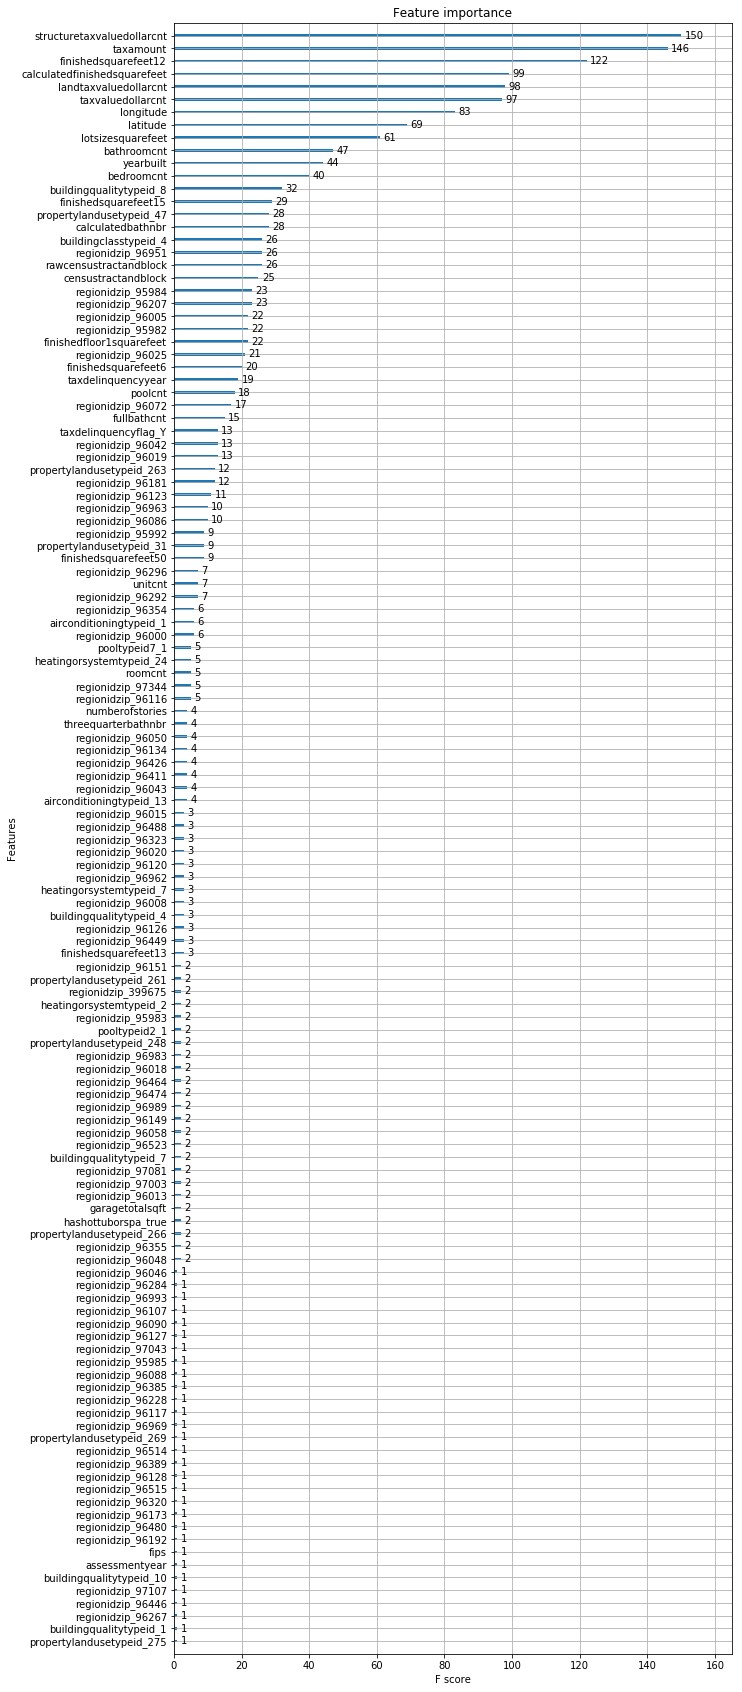

In [86]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(final_model, (10,30));

The plot above outlines how important each of the features was in making predictions for my final model. I find this graph very interesting, as there as about a quarter of all the features make up mose of the importance. Once of the most surprising things to me is that the majority of zip codes didn't amount to much. There were a few zip codes that were fairly predictive, but most of them had an f-score at or near 1. Longitude and latitude both rank high on importance, which is what I expected. If I were to keep iterating to make better models from here, I might try dropping most of the zip codes and only keeping the handful that are predictive. This would reduce dimensionality greatly and might make the model more generalizable.

What was surprising to me was that the tax statistics were so important! This might happen because the tax information likely wraps up a lot of information in one number. Neighborhoods with higher property taxes are usually the neighborhoods with really good schools, which means people are generally willing to pay more to live there. So the tax information might be important because it's a combination of proximity and also proximity to things like schools.

### Reflection
The goal of creating this model for the Zillow Kaggle competition is to model the Zestimate error as closely as possible. While it is still a bummer that they aren't going to provide competitors actual home price data for another 7 months, the process of designing, building, and tuning this model was still very educational for me.

I started exploring the data to familiarize myself with the various features--whether the were categorical or continuous, how many there were, what they related to, etc. I used the information from my data exploration to motivate processing steps to improve my model, which included filling in missing values, stardardizing continuous data, reducing dimensionality, and one-hot encoding categorical features. My next step was to feed the data into an xgBoost alrogirthm and tune the hyperparameters to achieve a better predictor. I used `GridSearchCV` to try dozens of parameter combinations for six different parameters--`max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, `gamma`, and `num_rounds`. After trianing a model that outperformed my benchmark model, I fed in the Kaggle competition data and submitted an entry into the competition.

I think that my model thouroughly solves the problem that I set out to solve. I was able to create a model that beat my benchmark and accurately predicts Zestimate errors. The entire problem is a little convoluted since I built a model to predict another model's error, but my average error is quite small and I think that it would be difficult to model another model's error perfectly. 

The aspect of my capstone that I found the most difficult is waiting for my models to train! One of my next learning goals is to use an AWS GPU instance to serve my iPython notebooks so that I don't have to wait as long. Not only does it make the machine learning process very time consuming, it also makes it more difficult to keep all of the context in your head while the model trains. I'm used to programming where I get instant feedback by refreshing a webpage, so waiting and trying not to let my mind wonder to other subjects while the training was happening was difficult. 

I also found the parameter tuning difficult because there is no best way to do it. I did a good amount of research on automated methods for finding parameters, but they all came with an asteriks and people on Kaggle and other reputable sites say that the parameters easily get stuck in local minima, take forever to train, etc. From what I read, the manual route is still the best route. This difficulty also ties back in to my training time complaints. Checking random combinations of hyperparameters wouldn't be so bad if you got instant feedback, but having to wait minutes or hours for results is tough.

### Improvements
There are many improvements that I could make to decrease the MAE of my model. While I could further tune my parameters, mess with the features, etc. I think that the strategy that would improve my model most would be ensembling. I have read on Kaggle that the winning submissions for competitions are usually an ensemble of models.

In particular, I might try training a random forest and a KNN model on the same data, predict the results, and then combine the predictions. This follows the rule that ensembling more prevents overfitting and improves your model. The gains might be minor, but in order to win competitions it seems like you usually need to ensemble several different types of models. I could also try training other xgBoost models that are tuned with different parameters. For example, I could ensemble a combination of three xgBoost models--one each of low, medium, and high complexity. The learning rate and number of training rounds could be adjusted to prevent overfitting based on the other parameters and the three models ensembled would likely outperform any one of the models. 

The one thing that I wish I understood better and could use more of is deep learning. I know that this competitions isn't necessarily the best use case for deep learning, but I think that there exists a neural network that could easily beat my model and perhaps even win the competition. Since I have an interest in deep learning and really liked the deep learning section of this course, I have already enrolled and started my Deep Learning Foundations Nanodegree. Maybe before this competition is over I will have the knowledge to come back and train a NN and try to beat my current model!